In [31]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [32]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [33]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [34]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [35]:
# Create an automap base
Base = automap_base()

# Reflect the database tables into the automap base
Base.prepare(engine, reflect=True)


In [36]:
Measurement = Base.classes.measurement
Station = Base.classes.station


In [37]:
# Access the dictionary of mapped classes
classes = Base.classes

# Print the names of the classes found in the database
for class_name in classes.keys():
    print(class_name)


measurement
station


In [38]:
# Create a session (link) from Python to the database
session = Session(engine)


In [56]:
# Query data from the Measurement table
results = session.query(Measurement).limit(10).all()

# Iterate through the results
for measurement in results:
     print(measurement.date, measurement.prcp, measurement.tobs)


2010-01-01 2.0 18.3
2010-01-02 0.0 17.2
2010-01-03 0.0 23.3
2010-01-04 0.0 24.4
2010-01-06 None 22.8
2010-01-07 1.5 21.1
2010-01-08 0.0 17.8
2010-01-09 0.0 20.0
2010-01-10 0.0 22.8
2010-01-11 0.3 17.8


In [ ]:
session.close()


In [ ]:
# ____________-------------------End------------

# Exploratory Precipitation Analysis

In [45]:
from sqlalchemy import func

# Find the most recent date in the data set
most_recent_date = session.query(func.max(Measurement.date)).scalar()

print("The most recent date in the data set is:", most_recent_date)


The most recent date in the data set is: 2017-08-23


In [46]:
from datetime import datetime, timedelta

# Calculate the most recent date in the data set
most_recent_date = session.query(func.max(Measurement.date)).scalar()

# Convert the most recent date to a datetime object
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year from the most recent date
one_year_ago = most_recent_date - timedelta(days=365)


In [ ]:
one_year_ago

In [47]:
from sqlalchemy import and_

# Query to retrieve the last 12 months of precipitation data
last_12_months_precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(and_(Measurement.date >= one_year_ago, Measurement.date <= most_recent_date)).\
    order_by(Measurement.date).all()


In [48]:
# Create a DataFrame from the query results
df = pd.DataFrame(last_12_months_precipitation, columns=['Date', 'Precipitation'])

# Set the 'Date' column as the DataFrame index
df.set_index('Date', inplace=True)


In [49]:
df.sort_index(inplace=True)


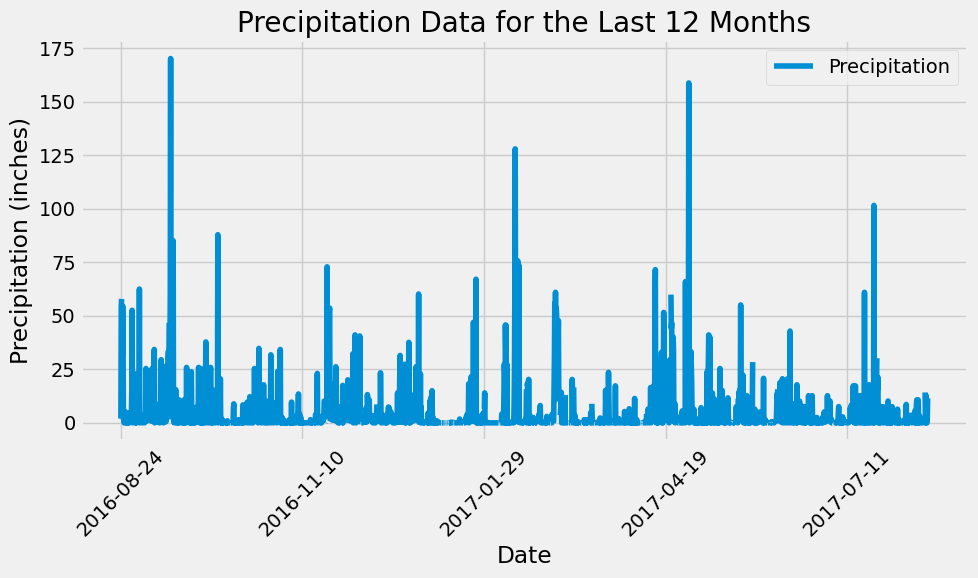

In [50]:

# Plot the data
df.plot(y='Precipitation', figsize=(10, 6))
plt.title("Precipitation Data for the Last 12 Months")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [51]:
# Calculate summary statistics for the precipitation data
summary_statistics = df.describe()

# Print the summary statistics
print(summary_statistics)


       Precipitation
count    2015.000000
mean        4.485112
std        11.690532
min         0.000000
25%         0.000000
50%         0.500000
75%         3.300000
max       170.200000


In [54]:
from sqlalchemy import distinct

# Query to calculate the total number of stations
total_stations = session.query(func.count(distinct(Station.station))).scalar()

print("Total number of stations in the dataset:", total_stations)


Total number of stations in the dataset: 9


In [55]:

# Query to find the most active stations and their counts
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

# Print the results
for station, count in active_stations:
    print(f"Station ID: {station}, Count: {count}")


Station ID: USC00519281, Count: 2772
Station ID: USC00519397, Count: 2724
Station ID: USC00513117, Count: 2709
Station ID: USC00519523, Count: 2669
Station ID: USC00516128, Count: 2612
Station ID: USC00514830, Count: 2202
Station ID: USC00511918, Count: 1979
Station ID: USC00517948, Count: 1372
Station ID: USC00518838, Count: 511


In [41]:

# Find the most active station (from the previous query)
most_active_station = active_stations[0][0]

# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs),
                                  func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

# Extract the results
lowest_temp, highest_temp, avg_temp = temperature_stats[0]

# Print the results
print(f"For the most active station ({most_active_station}):")
print(f"Lowest Temperature: {lowest_temp}°F")
print(f"Highest Temperature: {highest_temp}°F")
print(f"Average Temperature: {avg_temp:.2f}°F")


For the most active station (USC00519281):
Lowest Temperature: 12.2°F
Highest Temperature: 29.4°F
Average Temperature: 22.04°F


In [42]:
from datetime import datetime, timedelta

# Calculate the most recent date in the data set
most_recent_date = session.query(func.max(Measurement.date)).scalar()

# Convert the most recent date to a datetime object
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year from the most recent date
one_year_ago = most_recent_date - timedelta(days=365)


In [43]:
# Query the temperature observations for the most active station within the last 12 months
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()


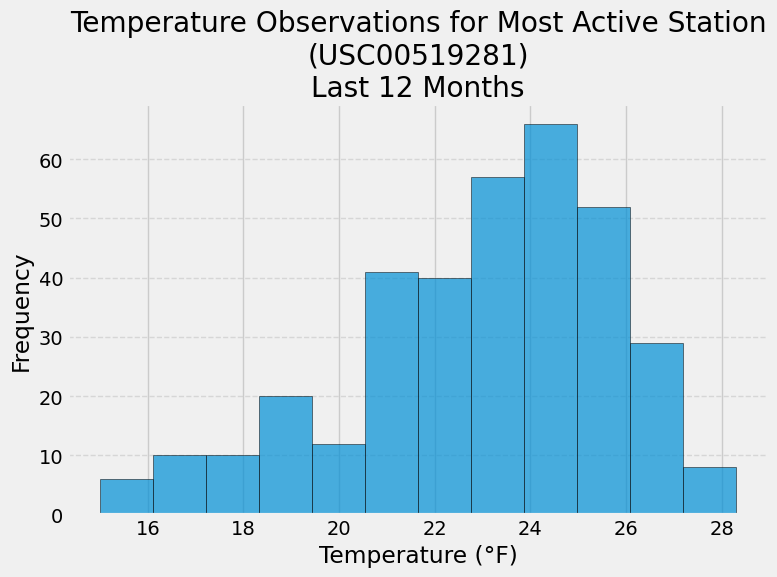

In [44]:
# Create a DataFrame from the query results
df = pd.DataFrame(temperature_data, columns=['Temperature (°F)'])

# Plot the data as a histogram
plt.figure(figsize=(8, 6))
plt.hist(df['Temperature (°F)'], bins=12, edgecolor='k', alpha=0.7)
plt.title(f"Temperature Observations for Most Active Station\n({most_active_station})\nLast 12 Months")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
# Close Session
session.close()